<a href="https://colab.research.google.com/github/lucywowen/csci547_ML/blob/main/Coffee_roasting_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install keras

In [38]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.colors as colors
from matplotlib import cm
from keras.layers import Dense, Input, Normalization
from keras.models import Sequential
from keras.activations import sigmoid
import matplotlib.colors as colors
from matplotlib import cm

In [39]:
def load_coffee_data():
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1,2)
    X[:,1] = X[:,1] * 4 + 11.5          # 12-15 min is best
    X[:,0] = X[:,0] * (285-150) + 150  # 350-500 F (175-260 C) is best
    Y = np.zeros(len(X))

    i=0
    for t,d in X:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (X, Y.reshape(-1,1))

def plt_prob(ax,fwb):
  """ plots a decision boundary but include shading to indicate the probability """
  #setup useful ranges and common linspaces
  x0_space  = np.linspace(150, 285 , 40)
  x1_space  = np.linspace(11.5, 15.5 , 40)
  # get probability for x0,x1 ranges
  tmp_x0,tmp_x1 = np.meshgrid(x0_space,x1_space)
  z = np.zeros_like(tmp_x0)
  for i in range(tmp_x0.shape[0]):
      for j in range(tmp_x1.shape[1]):
          x = np.array([[tmp_x0[i,j],tmp_x1[i,j]]])
          z[i,j] = fwb(x)


  cmap = plt.get_cmap('Blues')
  new_cmap = truncate_colormap(cmap, 0.0, 0.5)
  pcm = ax.pcolormesh(tmp_x0, tmp_x1, z, norm=cm.colors.Normalize(vmin=0, vmax=1), cmap=new_cmap, shading='nearest', alpha = 0.9)
  ax.figure.colorbar(pcm, ax=ax)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
  """ truncates color map """
  new_cmap = colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
                                                      cmap(np.linspace(minval, maxval, n)))
  return new_cmap

dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0', dldarkblue =  '#0D5BDC')
def plotData(X, Y):
    Y = Y.reshape(-1,)
    colormap = np.array(['r', 'b'])
    fig, ax = plt.subplots(1,1,)
    ax.scatter(X[Y==1,0],X[Y==1,1], s=70, marker='x', c='red', label="Good Roast" )
    ax.scatter(X[Y==0,0],X[Y==0,1], s=100, marker='o', facecolors='none',
                   edgecolors=dlc["dldarkblue"],linewidth=1,  label="Bad Roast")
    tr = np.linspace(175,260,50)
    ax.plot(tr, (-3/85) * tr + 21, color=dlc["dlpurple"],linewidth=1)
    ax.axhline(y=12,color=dlc["dlpurple"],linewidth=1)
    ax.axvline(x=175,color=dlc["dlpurple"],linewidth=1)
    ax.set_title(f"Coffee Roasting", size=16)
    ax.set_xlabel("Temperature \n(Celsius)",size=12)
    ax.set_ylabel("Duration \n(minutes)",size=12)
    ax.legend(loc='upper right')
    plt.show()


In [67]:
X, Y = load_coffee_data();

In [ ]:
plotData(X, Y)

In [69]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
norm_l = Normalization(axis=-1)
norm_l.adapt(X)  # learns mean, variance
Xn = norm_l(X)
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


In [70]:
Xt = np.tile(Xn,(1000,1))
Yt= np.tile(Y,(1000,1))
print(Xt.shape, Yt.shape)

(200000, 2) (200000, 1)


In [71]:
tf.random.set_seed(1234)  # applied to achieve consistent results
model = Sequential(
    [
        Input(shape=(2,)),
        Dense(3, activation='sigmoid', name = 'layer1'),
        Dense(1, activation='sigmoid', name = 'layer2')
     ]
)

In [72]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                       │ (None, 3)                   │               9 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer2 (Dense)                       │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

In [73]:
L1_num_params = 2 * 3 + 3   # W1 parameters  + b1 parameters
L2_num_params = 3 * 1 + 1   # W2 parameters  + b2 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params  )

L1 params =  9 , L2 params =  4


In [74]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[-0.7358693   0.1740756   0.8433995 ]
 [ 0.849926    0.7053814   0.07415557]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[-1.1604764 ]
 [-0.6309899 ]
 [-0.14371026]] 
b2(1,): [0.]


In [75]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    Xt,Yt,
    epochs=10,
)

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.2451
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.1184
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0453
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0171
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0110
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0077
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0055
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0039
Epoch 9/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0028
Epoch 10/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0021


In [82]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[-8.94  0.29 12.89]
 [-0.17 -7.34 10.79]] 
b1: [-9.87 -9.28  1.01]
W2:
 [[-31.38]
 [-27.86]
 [-32.79]] 
b2: [15.54]


In [110]:
W1 = np.array([
    [-8.94,  0.29, 12.89],
    [-0.17, -7.34, 10.79]] )
b1 = np.array([-9.87, -9.28,  1.01])
W2 = np.array([
    [-31.38],
    [-27.86],
    [-32.79]])
b2 = np.array([15.54])
model.get_layer("layer1").set_weights([W1,b1])
model.get_layer("layer2").set_weights([W2,b2])

In [111]:
X_test = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
predictions = 
 [[9.625127e-01]
 [3.031606e-08]]


In [112]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


In [113]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


In [114]:
import sklearn.neural_network
# Create an instance of the MLPClassifier class
neural_network = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(3, 1), activation='logistic')
 # Fit the model to the training data
neural_network.fit(Xt,Yt)
y_pred_prob = neural_network.predict_proba(X_testn)
# Predict the labels of new data
y_pred = neural_network.predict(X_testn)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [115]:
y_pred_prob

array([[1.7881393e-06, 9.9999821e-01],
       [9.9999958e-01, 4.3878433e-07]], dtype=float32)

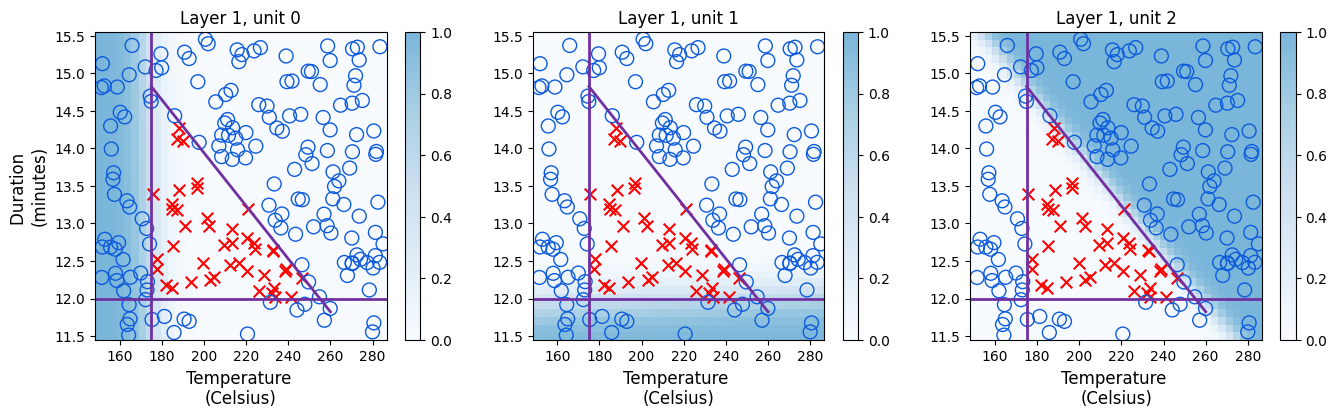

In [99]:
plt_layer(X,Y.reshape(-1,),W1,b1,norm_l)